## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
# import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, average_precision_score
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import pickle

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.DataFrame(pd.read_csv('./training.csv'))
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


### Data Exploration

In [2]:
# Missing value check
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
#Change data type of variable "Promotion" to boolean
#train_data['Promotion'] = list(map(lambda x: 1 if x == "Yes" else 0, train_data['Promotion']))
#train_data['Promotion'].head(10)

count    84534.000000
mean        29.973600
std          5.010626
min          7.104007
25%         26.591501
50%         29.979744
75%         33.344593
max         50.375913
Name: V2, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1bb6604ba58>,
 'caps': [<matplotlib.lines.Line2D at 0x1bb66062048>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bb6604b7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1bb660625f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bb660628d0>],
 'means': []}

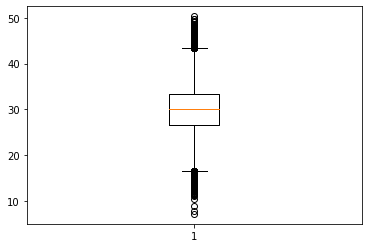

In [5]:
# Variable "V2"
print (train_data['V2'].describe())
plt.boxplot(train_data['V2'])

count    84534.000000
mean         0.000190
std          1.000485
min         -1.684550
25%         -0.905350
50%         -0.039572
75%          0.826206
max          1.691984
Name: V3, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1bb663879e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1bb66387f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bb66387780>],
 'medians': [<matplotlib.lines.Line2D at 0x1bb6639a588>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bb6639a860>],
 'means': []}

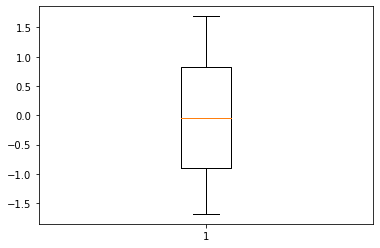

In [6]:
# Variable "V3"
print (train_data['V3'].describe())
plt.boxplot(train_data['V3'])

In [7]:
# Variable "V4"
print (" Variable 'V4':")
print (train_data['V4'].describe())
print (train_data['V4'].value_counts())

# Variable "V5"
print ("\n Variable 'V5':")
print (train_data['V5'].describe())
print (train_data['V5'].value_counts())

# Variable "V6"
print ("\n Variable 'V6':")
print (train_data['V6'].describe())
print (train_data['V6'].value_counts())

# Variable "V7"
print ("\n Variable 'V7':")
print (train_data['V7'].describe())
print (train_data['V7'].value_counts())

 Variable 'V4':
count    84534.000000
mean         1.679608
std          0.466630
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: V4, dtype: float64
2    57450
1    27084
Name: V4, dtype: int64

 Variable 'V5':
count    84534.000000
mean         2.327643
std          0.841167
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: V5, dtype: float64
3    32743
2    31196
1    15412
4     5183
Name: V5, dtype: int64

 Variable 'V6':
count    84534.000000
mean         2.502898
std          1.117349
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: V6, dtype: float64
3    21186
4    21176
2    21146
1    21026
Name: V6, dtype: int64

 Variable 'V7':
count    84534.000000
mean         1.701694
std          0.457517
min          1.000000
25%          1.000000
50%          2.000000
75%          2.0000

In [8]:
# See some statistics of variables in each group (Promotion and non-Promotion)
GrpByProm = train_data.groupby('Promotion')
GrpByProm.agg(['mean', 'median'])

ID         purchase               V1                V2  \
                   mean median      mean median      mean median       mean   
Promotion                                                                     
No         63094.836661  62922  0.007565      0  1.496277      1  29.976876   
Yes        62847.675385  62717  0.017019      0  1.505028      2  29.970338   

                            V3                  V4               V5         \
              median      mean    median      mean median      mean median   
Promotion                                                                    
No         29.969732 -0.007099 -0.039572  1.680270      2  2.330638      2   
Yes        29.989227  0.007446  0.047006  1.678949      2  2.324662      2   

                 V6               V7         
               mean median      mean median  
Promotion                                    
No         2.501565      3  1.702205      2  
Yes        2.504225      3  1.701185      2

In [9]:
# See some statistics of variables in each group (purchase and not-purchase)
GrpByPur = train_data.groupby('purchase')
GrpByPur.agg(['mean', 'median'])

ID                 V1                V2             \
                  mean   median      mean median       mean     median   
purchase                                                                 
0         62942.917383  62784.5  1.501138      2  29.974547  29.978916   
1         65223.305769  65986.5  1.462500      1  29.897554  30.005909   

                V3                  V4               V5              V6  \
              mean    median      mean median      mean median     mean   
purchase                                                                  
0         0.000905 -0.039572  1.677929      2  2.326910      2  2.50309   
1        -0.057137 -0.126150  1.814423      2  2.386538      3  2.48750   

                       V7         
         median      mean median  
purchase                          
0             3  1.701751      2  
1             2  1.697115      2

In [10]:
# Average value of each variable in four sub-groups: purchase and non-purchase, promotion and non-promotion
variables = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
train_data.groupby(['purchase', 'Promotion'])[variables].agg(['mean'])

V1         V2        V3        V4        V5  \
                        mean       mean      mean      mean      mean   
purchase Promotion                                                      
0        No         1.496738  29.976837 -0.007828  1.680175  2.330434   
         Yes        1.505559  29.972246  0.009680  1.675672  2.323368   
1        No         1.435737  29.982026  0.088530  1.692790  2.357367   
         Yes        1.474341  29.860180 -0.121587  1.868239  2.399445   

                          V6        V7  
                        mean      mean  
purchase Promotion                      
0        No         2.501661  1.702014  
         Yes        2.504527  1.701486  
1        No         2.489028  1.727273  
         Yes        2.486824  1.683773

After basic data exploration, we could find that the data seems reasonable in each variable, and some differences could be observed between sub-groups. No more data cleaning is needed in this problem.

We then test whether the two groups (experiment group and control group) have equal size. The null hypothesis is the two groups have equal size. To reject this hypothesis, p-value should be smaller than 0.05.

In [11]:
# The number of total individuals, and numbers of individuals in each group
N = train_data.shape[0]
n_exp = train_data[train_data['Promotion'] == "Yes"].shape[0]
n_ctr = train_data[train_data['Promotion'] == "No"].shape[0]

print ("Total number of individuals in the training dataset: {}".format(N))
print ("Promotion Group Size: {}".format(n_exp))
print ("Non-Promotion Group Size: {}".format(n_ctr))

Total number of individuals in the training dataset: 84534
Promotion Group Size: 42364
Non-Promotion Group Size: 42170


In [12]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * N)

z = ((n_ctr + 0.5) - p * N) / sd

print("z score:", z)
print("p-value:", 2 * sp.stats.norm.cdf(z))

z score: -0.6638066506192843
p-value: 0.5068140685419046


As shown above, the p-value is 0.5068 > 0.05, which means that both groups are equal-sized.  

We then see the purchase ratio and the two metrics (IRR and NIR)

In [13]:
# Purchase rate in each group
pur_ratio_exp = train_data[(train_data['purchase'] == 1) & (train_data['Promotion'] == 'Yes')].shape[0] / n_exp
pur_ratio_ctr = train_data[(train_data['purchase'] == 1) & (train_data['Promotion'] == 'No')].shape[0] / n_ctr
print ("Purchase rate in experiment group: {}".format(pur_ratio_exp))
print ("Purchase rate in control group: {}".format(pur_ratio_ctr))

Purchase rate in experiment group: 0.017019167217448776
Purchase rate in control group: 0.007564619397676073


In [14]:
# Define functions for the two basic metrics: IRR, and NIR

def getIRR(df):
    '''
    A function calculating IRR from the dataframe with columns for 'Promotion' and 'purchase'
    
    Input:
        df: a dataframe with columns 'Promotion' and 'purchase'
    
    Output: 
        irr: a value of the incremental response rate (IRR)
    '''
    
    # Number of individuals in Promotion and Non-promotion groups
    n_exp = df[df['Promotion'] == "Yes"].shape[0]
    n_ctr = df[df['Promotion'] == "No"].shape[0]
    
    # Purchase rate in Promotion and Non-promotion groups
    pur_ratio_exp = df[(df['purchase'] == 1) & (df['Promotion'] == 'Yes')].shape[0] / n_exp
    pur_ratio_ctr = df[(df['purchase'] == 1) & (df['Promotion'] == 'No')].shape[0] / n_ctr

    # Calculate IRR
    irr = pur_ratio_exp - pur_ratio_ctr
    
    return irr


def getNIR(df):
    '''
    A function calculating NIR from the dataframe with columns 'Promotion' and 'purchase'
    
    Input:
        df: a dataframe with columns 'Promotion' and 'purchase'
    
    Output: 
        irr: a value of the net incremental revenue (NIR)
    '''

    # Number of Purchases in Promotion and Non-promotion groups
    pur_exp = df[(df['purchase'] == 1) & (df['Promotion'] == 'Yes')].shape[0]
    pur_ctr = df[(df['purchase'] == 1) & (df['Promotion'] == 'No')].shape[0]

    # Number of Promotions sent out
    n_exp = df[df['Promotion'] == "Yes"].shape[0]
    
    # Calculate NIR
    nir = (10 * pur_exp - 0.15 * n_exp) - 10 * pur_ctr
    
    return nir

In [15]:
# Now we could calculate IRR and NIR for our original training dataframe.
print ("IRR:", getIRR(train_data))
print ("NIR:", getNIR(train_data))

IRR: 0.009454547819772702
NIR: -2334.5999999999995


In [16]:
# Define a function calculating the confidence intervals for IRR and NIR
# Use bootstrap method

def getCI(df, c = 0.95, n_trials = 10000):
    
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap method.
    
    Input:
        df: a dataframe with columns 'Promotion' and 'purchase' 
        c: confidence interval level, with a default value of 0.95 (95%)
        n_trials: number of bootstrap trials to conduct, with a default value of 10000
    
    Output:
        Confidence interval or IRR and NIR
    """
        
    # initialize IRR and NIR lists to save IRR and NIR values obtained in each trial
    n_points = df.shape[0]
    irr_list = []
    nir_list = []
    
    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = np.random.choice(df.index, df.shape[0], replace = True)
        
        # compute IRR and NIR for the sample
        sample_irr = getIRR(df.iloc[sample])
        sample_nir = getNIR(df.iloc[sample])
        
        # and add the value to the list of IRR and NIR
        irr_list.append(sample_irr)
        nir_list.append(sample_nir)
        
    # Compute the confidence interval bounds for IRR and NIR
    irr_CI = [np.percentile(irr_list, (1 - c)/2 * 100), np.percentile(irr_list, (1 + c)/2 * 100)]
    nir_CI = [np.percentile(nir_list, (1 - c)/2 * 100), np.percentile(nir_list, (1 + c)/2 * 100)]
    
    print ("IRR {} Confidence Interval: {} \nNir {} Confidence Interval: {}".format(c, irr_CI, c, nir_CI))
    
    return irr_CI, nir_CI

We are now able to calculate the CIs of IRR and NIR for the train_data.  

Notice that there are two metrics here. Thus, we use Bonferroni Correction:  
$$\text{Bonferroni Correction} = \frac{\alpha}  {\text{number of metrics}} = \frac{0.5}{2} = 0.025 $$

In [17]:
getCI(train_data, 0.975, 5000)

IRR 0.975 Confidence Interval: [0.007734642906383367, 0.011129844443801957] 
Nir 0.975 Confidence Interval: [-3069.1549999999997, -1625.88]


([0.007734642906383367, 0.011129844443801957], [-3069.1549999999997, -1625.88])

### Modeling

From previous exploration, we know several variables are categorical variables, which could be transformed to dummy variables before processing.

In [18]:
#set X variable and get dummy variables for each feature within
X = train_data.iloc[:,3:]
X = pd.get_dummies(data = X, columns=['V1','V4', 'V5','V6','V7'], drop_first = True)
y = train_data['purchase']

In [19]:
# Further split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,V2,V3,V1_1,V1_2,V1_3,V4_2,V5_2,V5_3,V5_4,V6_2,V6_3,V6_4,V7_2
66588,34.470493,-1.078506,0,0,1,0,0,0,0,0,0,0,1
62125,28.065819,-1.165083,1,0,0,0,0,0,0,0,1,0,0
27827,27.142590,-1.511395,1,0,0,0,0,1,0,0,1,0,1
66648,28.782344,-1.078506,0,0,1,0,0,0,0,0,0,0,1
47392,39.605508,-0.645617,0,1,0,1,0,1,0,0,0,0,1


In [20]:
# Fit Gradient Boosting Classifier
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)

# Make prediction, present the confusion matrix and accuracy
y_pred = GBC.predict(X_test)
print(confusion_matrix(y_test, y_pred))

(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tn + fp + fn + tp)

print ('Accuracy: {}'.format(accuracy))
print ('Precision: {}'.format(precision))
print ('Recall: {}'.format(recall))

[[16678    21]
 [  208     0]]
Accuracy: 0.9864553143668303
Precision: 0.0
Recall: 0.0


In [21]:
y_pred = list(map(lambda x: "Yes" if x == 1 else "No", y_pred))
fit_df = pd.DataFrame({"Promotion": y_pred, "purchase": y_test})
print ("IRR:", getIRR(fit_df))
print ("NIR:", getNIR(fit_df))

IRR: -0.012317896482293023
NIR: -2083.15


We could see that the model prediction results are worse than the default promotion strategy. This is because the dataset is highly imbalanced due to too few people purchase the product, which can lead to biased algorithm: we could obtain a very high accuracy by always predicting that the customer will not purchase the product. 

To deal with the algorithm learning with imbalanced dataset, a downsample method and an upsampling method could be applied, such that the number of individuals who purchase the product and do not purchase the product are balanced in the training set. 

Then we re-train the model.

#### DownSampling

In [22]:
# DownSampling Method
promo_sample_idx = np.random.choice(train_data[train_data["purchase"] == 0].index, 
                                    train_data[train_data["purchase"] == 1].shape[0], 
                                    replace = False)
promo_sample = train_data.iloc[promo_sample_idx]
dns_df = pd.concat([promo_sample, train_data[train_data["purchase"] == 1]])

In [23]:
#set X variable and get dummy variables for each feature within
X = dns_df.iloc[:,3:]
X = pd.get_dummies(data = X, columns=['V1','V4', 'V5','V6','V7'], drop_first = True)
y = dns_df['purchase']

# Further split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,V2,V3,V1_1,V1_2,V1_3,V4_2,V5_2,V5_3,V5_4,V6_2,V6_3,V6_4,V7_2
81188,29.335677,1.345672,1,0,0,1,1,0,0,0,0,1,1
31884,22.808890,-0.559039,0,0,0,1,0,0,0,0,1,0,0
39566,24.581469,0.306739,0,1,0,1,0,1,0,0,1,0,1
54153,32.660111,0.047006,1,0,0,1,0,1,0,0,0,1,1
17446,31.074061,-1.338239,0,1,0,1,0,1,0,0,0,1,1


In [24]:
# Fit Gradient Boosting Classifier
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)

# Make prediction, present the confusion matrix and accuracy
y_pred = GBC.predict(X_test)
print(confusion_matrix(y_test, y_pred))

(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tn + fp + fn + tp)

print ('Accuracy: {}'.format(accuracy))
print ('Precision: {}'.format(precision))
print ('Recall: {}'.format(recall))

[[104 109]
 [ 72 131]]
Accuracy: 0.5649038461538461
Precision: 0.5458333333333333
Recall: 0.645320197044335


In [25]:
y_pred = list(map(lambda x: "Yes" if x == 1 else "No", y_pred))
fit_df = pd.DataFrame({"Promotion": y_pred, "purchase": y_test})
print ("IRR:", getIRR(fit_df))
print ("NIR:", getNIR(fit_df))

IRR: 0.13674242424242417
NIR: 554.0


#### UpSampling

In [26]:
# UpSampling Method
promo_sample_idx = np.random.choice(train_data[train_data["purchase"] == 1].index, 
                                    train_data[train_data["purchase"] == 0].shape[0], 
                                    replace = True)
promo_sample = train_data.iloc[promo_sample_idx]
ups_df = pd.concat([promo_sample, train_data[train_data["purchase"] == 0]])

In [27]:
#set X variable and get dummy variables for each feature within
X = ups_df.iloc[:,3:]
X = pd.get_dummies(data = X, columns=['V1','V4', 'V5','V6','V7'], drop_first = True)
y = ups_df['purchase']

# Further split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,V2,V3,V1_1,V1_2,V1_3,V4_2,V5_2,V5_3,V5_4,V6_2,V6_3,V6_4,V7_2
14335,37.905682,-1.165083,0,0,1,1,0,1,0,0,0,1,1
34700,26.773433,-0.212728,0,0,0,0,1,0,0,1,0,0,1
59062,28.656123,-0.126150,0,0,1,0,0,0,0,1,0,0,1
57354,35.972148,-1.684550,0,1,0,1,0,1,0,0,0,1,1
10270,30.900568,0.133583,0,1,0,1,0,0,1,0,0,1,1


In [28]:
# Fit Gradient Boosting Classifier
GBC = GradientBoostingClassifier()
GBC.fit(X_train, y_train)

# Make prediction, present the confusion matrix and accuracy
y_pred = GBC.predict(X_test)
print(confusion_matrix(y_test, y_pred))

(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tn + fp + fn + tp)

print ('Accuracy: {}'.format(accuracy))
print ('Precision: {}'.format(precision))
print ('Recall: {}'.format(recall))

[[ 9817  6991]
 [ 4684 11906]]
Accuracy: 0.6504281693514582
Precision: 0.6300470974228713
Recall: 0.7176612417118746


In [29]:
y_pred = list(map(lambda x: "Yes" if x == 1 else "No", y_pred))
fit_df = pd.DataFrame({"Promotion": y_pred, "purchase": y_test})
print ("IRR:", getIRR(fit_df))
print ("NIR:", getNIR(fit_df))

IRR: 0.3070348913681165
NIR: 69385.45


### Gradient Boosting Pipeline

From above we could see that upsampling show better performance than downsampling. This may be because down sampling omit too many data points thus cause significant information loss.  
Thus, we use upsampling to further improve the learning model.

In [30]:
pipeline_GBC = Pipeline([
            ('clf', GradientBoostingClassifier())
        ])
pipeline_GBC.get_params()

{'memory': None,
 'steps': [('clf', GradientBoostingClassifier())],
 'verbose': False,
 'clf': GradientBoostingClassifier(),
 'clf__ccp_alpha': 0.0,
 'clf__criterion': 'friedman_mse',
 'clf__init': None,
 'clf__learning_rate': 0.1,
 'clf__loss': 'deviance',
 'clf__max_depth': 3,
 'clf__max_features': None,
 'clf__max_leaf_nodes': None,
 'clf__min_impurity_decrease': 0.0,
 'clf__min_impurity_split': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 100,
 'clf__n_iter_no_change': None,
 'clf__presort': 'deprecated',
 'clf__random_state': None,
 'clf__subsample': 1.0,
 'clf__tol': 0.0001,
 'clf__validation_fraction': 0.1,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [58]:
def build_model():

    """
    A machine learning pipeline contains: 
        - Gradient Boosting Classification model training
        - gridsearch hyperparameters tuning
    
    Inputs: 
        None
    Output: 
        cv: pipeline represented by a GridSearchCV object
    """

    pipeline_GBC = Pipeline([
            ('clf', GradientBoostingClassifier())
        ])
        
    parameters = {
#        'clf__n_estimators': [50, 100, 200],
#        'clf__max_depth': [5, 10, None],
#        'clf__min_samples_split': [2, 5, 10]
    }

    cv = GridSearchCV(pipeline_GBC, param_grid=parameters)
    
    return cv

model_GBC = build_model()
model_GBC.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('clf', GradientBoostingClassifier())]),
             param_grid={})

In [55]:
model_GBC.best_params_

{'clf__max_depth': None}

In [59]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    X = pd.get_dummies(data = df, columns=['V1','V4', 'V5','V6','V7'], drop_first = True)
    y_pred = model_GBC.predict(X)
    promotion = np.array(list(map(lambda x: "Yes" if x == 1 else "No", y_pred)))
    
    return promotion

In [60]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0200.

Your nir with this strategy is 426.20.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.020027930048123605, 426.20000000000005)

IRR obtained from our Gradient Boosting Classifier model is out of the 97.5% confidence level of the original promotion strategy, which means that the proposed strategy is definitely better than the default strategy. Meanwhile, the IRR and NIR obtained from our model are also higher than the results given by the embedded algorithm (created by Udacity). 

In [62]:
# Finally, let's export the trained model as pickle file.

pickle_out = open("model_GBC.pkl", 'wb')
pickle.dump(model_GBC, pickle_out)
pickle_out.close()